# APDS-9960 Gesture Data Playground

Experimenting with different methods of processing APDS-9960 gesture data

## Gesture Data Formats

Gesture data is gathered by the sensor and stored in a 32-block FIFO which can be read via I2C either one block at a time or in a "page read" of the entire FIFO all at once. Each "block" is referred to in the datasheet as a "dataset".

Individual "datasets" are effectively a four-byte tuple of 8-bit unsigned ints. Each contains ADC count data from the "up", "down", "left", and "right" photodiodes, in that sequence. `0` represents "far" and `255` represents "near".

Here's a single sample of what that data looks like.

In [30]:
dataset_example = (123, 152, 151, 33)

And these are some sequences of datasets captured during normal use with test driver code.

These were collected with the following settings:

```py
apds.gesture_proximity_threshold = 5
apds.gesture_exit_threshold = 100
apds.gesture_exit_persistence = 2
apds.gesture_fifo_threshold = 1
apds.gesture_wait_time = 2
apds.gesture_gain = 1
apds.gesture_pulses = 8
apds.gesture_pulse_length = 1
```

From here, I'll use "dataset" to refer to a single 4-int tuple and "dataframe" to refer to a sequential list of datasets like the four below.

In [31]:
up_swipe = [
    (98, 16, 56, 70),
    (141, 38, 89, 108),
    (194, 73, 131, 151),
    (255, 122, 179, 203),
    (255, 186, 242, 255),
    (238, 255, 231, 230),
    (187, 228, 182, 188),
    (136, 186, 136, 152),
    (93, 147, 96, 118),
    (57, 106, 61, 86),
    (31, 74, 36, 59),
    (16, 49, 18, 39),
    (6, 29, 9, 26),
    (0, 14, 0, 12)]

down_swipe = [
    (35, 81, 45, 83),
    (83, 136, 89, 129),
    (141, 184, 138, 175),
    (197, 218, 184, 211),
    (241, 235, 222, 236),
    (255, 246, 247, 254),
    (255, 253, 255, 255),
    (255, 253, 255, 255),
    (255, 233, 248, 255),
    (255, 209, 214, 255),
    (255, 172, 173, 248),
    (240, 130, 132, 207),
    (186, 81, 84, 153),
    (130, 36, 49, 104),
    (81, 11, 21, 59),
    (43, 0, 5, 27),
    (18, 0, 0, 10)]

left_swipe = [
    (55, 74, 93, 38),
    (101, 118, 141, 83),
    (150, 151, 171, 132),
    (181, 166, 174, 167),
    (198, 173, 170, 186),
    (203, 166, 157, 190),
    (197, 158, 149, 185),
    (187, 151, 142, 176),
    (172, 141, 132, 165),
    (162, 131, 121, 157),
    (151, 121, 110, 150),
    (143, 116, 98, 135),
    (125, 101, 88, 128),
    (111, 88, 71, 116),
    (94, 72, 49, 99),
    (69, 51, 26, 79),
    (45, 30, 8, 53),
    (24, 13, 0, 28)]

right_swipe = [
    (65, 47, 21, 90),
    (106, 84, 55, 132),
    (163, 126, 103, 182),
    (217, 169, 158, 218),
    (254, 198, 209, 232),
    (255, 212, 244, 236),
    (255, 215, 255, 235),
    (255, 215, 255, 231),
    (255, 213, 255, 232),
    (255, 216, 253, 234),
    (255, 225, 255, 243),
    (255, 239, 255, 254),
    (255, 249, 255, 255),
    (255, 249, 255, 255),
    (255, 245, 255, 255),
    (255, 244, 255, 255),
    (255, 248, 255, 255),
    (255, 248, 255, 255),
    (255, 247, 255, 238),
    (255, 237, 255, 213),
    (227, 222, 244, 183),
    (192, 203, 217, 148),
    (154, 176, 185, 116),
    (116, 148, 152, 89),
    (87, 121, 123, 64),
    (62, 95, 94, 46),
    (43, 74, 73, 33),
    (32, 58, 57, 27),
    (22, 46, 44, 18)]

The data within aech dataset represents the ADC counts recorded during a gesture measurement. The analog measurements represent reflections returned from pulses of an IR LED. In these data, `0` represents "far" and `255` represents "near".

Here's what these four look like plotted over time.

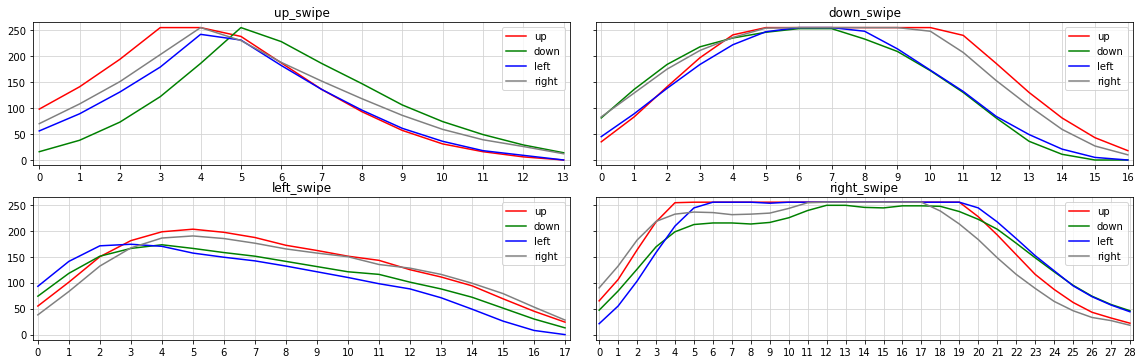

In [188]:
import matplotlib.pyplot as plt

def plot_dataframe(name, dataframe, axis):
    axis.set_title(name)
    axis.set(ylim=(-5, 260))
    axis.plot([dataset[0] for dataset in dataframe], color='red', label='up')
    axis.plot([dataset[1] for dataset in dataframe], color='green', label='down')
    axis.plot([dataset[2] for dataset in dataframe], color='blue', label='left')
    axis.plot([dataset[3] for dataset in dataframe], color='gray', label='right')
    axis.legend(loc="upper right")
    axis.set(xlim=(-0.15, len(dataframe) - 0.85), ylim=(-10,265))
    axis.grid(visible=True, color="lightgray")
    axis.set_xticks(range(len(dataframe)))
    axis.set_yticks(range(0, 260, 50))

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(16,5))
fig.tight_layout()
plot_dataframe("up_swipe", up_swipe, axs[0,0])
plot_dataframe("down_swipe", down_swipe, axs[0,1])
plot_dataframe("left_swipe", left_swipe, axs[1,0])
plot_dataframe("right_swipe", right_swipe, axs[1,1])


We can process this a few different ways, which is where the fun really starts.

The most comprehensive algorithm I could find was from the [SparkFun Ardunio library code on GitHub](https://github.com/sparkfun/SparkFun_APDS-9960_Sensor_Arduino_Library/blob/master/src/SparkFun_APDS9960.cpp).

Below is a quick-and-dirty translation of this algorithm into more snakey code.

In [147]:
def gesture_decode_arduino_lib(gesture_data):
    gesture_motion = "none"
    
    if not gesture_data:
        return 0

    # if (0, 0, 0, 0) in (gesture_data):
    #     print("GEST ANALYSIS | Junk data, all zeroes present")
    #     return 0

    if len(gesture_data) > 0:
        # print("GEST ANALYSIS | Start Gesture Analysis")

        zeroes = (0, 0, 0, 0)
        first_data = zeroes
        last_data = zeroes
        GESTURE_THRESHOLD_OUT = 30

        # Find first/last values
        for early_gesture_tuple in gesture_data:
            # if [(gv > thr) for gv, thr in zip(early_gesture_tuple, GESTURE_THRESHOLD_OUT)]
            if (early_gesture_tuple[0] > GESTURE_THRESHOLD_OUT and
                early_gesture_tuple[1] > GESTURE_THRESHOLD_OUT and
                early_gesture_tuple[2] > GESTURE_THRESHOLD_OUT and
                early_gesture_tuple[3] > GESTURE_THRESHOLD_OUT):
                    first_data = early_gesture_tuple
                    break # Stop iterating on our first hit

        # print("GEST ANALYSIS | First: {}".format(first_data))

        for reverse_gesture_tuple in reversed(gesture_data):
            if (reverse_gesture_tuple[0] > GESTURE_THRESHOLD_OUT and
                reverse_gesture_tuple[1] > GESTURE_THRESHOLD_OUT and
                reverse_gesture_tuple[2] > GESTURE_THRESHOLD_OUT and
                reverse_gesture_tuple[3] > GESTURE_THRESHOLD_OUT):
                    last_data = reverse_gesture_tuple
                    break # Stop iterating on our first hit

        # print("GEST ANALYSIS | Last:  {}".format(last_data))

        if first_data == zeroes or last_data == zeroes:
            # print("GEST ANALYSIS | Junk data, all under useful thresholds")
            return gesture_data

        # Ratios and Deltas
        ud_ratio_first = ((first_data[0] - first_data[1]) * 100) / (first_data[0] + first_data[1])
        lr_ratio_first = ((first_data[2] - first_data[3]) * 100) / (first_data[2] + first_data[3])
        ud_ratio_last = ((last_data[0] - last_data[1]) * 100) / (last_data[0] + last_data[1])
        lr_ratio_last = ((last_data[2] - last_data[3]) * 100) / (last_data[2] + last_data[3])


        # Calculate delta betwen first and last ratios
        ud_delta = ud_ratio_last - ud_ratio_first
        lr_delta = lr_ratio_last - lr_ratio_first

        # print("GEST ANALYSIS | UD Ratio | First: {}, Last: {}, Delta: {}".format(ud_ratio_first, ud_ratio_last, ud_delta))
        # print("GEST ANALYSIS | LR Ratio | First: {}, Last: {}, Delta: {}".format(lr_ratio_first, lr_ratio_last, lr_delta))

        # Accumulate UD/LR deltas
        # gesture_ud_delta += ud_delta ## These are class vars in the actual code but we don't need to persist anything
        # gesture_lr_delta += lr_delta
        gesture_ud_delta = ud_delta
        gesture_lr_delta = lr_delta

        GESTURE_SENSITIVITY_1 = 50
        # GESTURE_SENSITIVITY_2 = 20

        # Basic Gesture Determination
        # Determine U/D Gesture
        if gesture_ud_delta >= GESTURE_SENSITIVITY_1:
            gesture_ud_count = 1
        elif gesture_ud_delta <= -GESTURE_SENSITIVITY_1:
            gesture_ud_count = -1
        else:
            gesture_ud_count = 0

        # Determine L/R Gesture
        if gesture_lr_delta >= GESTURE_SENSITIVITY_1:
            gesture_lr_count = 1
        elif gesture_lr_delta <= -GESTURE_SENSITIVITY_1:
            gesture_lr_count = -1
        else:
            gesture_lr_count = 0
        
        ## This relies on global vars so we won't be using this either
        # # Determine Near/Far Gesture
        # if gesture_ud_count == 0 and gesture_lr_count == 0:
        #     if abs(ud_delta) < GESTURE_SENSITIVITY_2 and \
        #         abs(lr_delta) < GESTURE_SENSITIVITY_2:

        #         # if ud_delta == 0 and lr_delta == 0:
        #         #     gesture_near_count += 1
        #         # elif ud_delta != 0 and lr_delta != 0:
        #         #     gesture_far_count += 1

        #         # if gesture_near_count >= 10 and gesture_far_count >= 2:
        #         #     if ud_delta == 0 and lr_delta == 0:
        #         #         gesture_state = "near"
        #         #     elif ud_delta != 0 and lr_delta != 0:
        #         #         gesture_state = "far"
        # else:
        #     if abs(ud_delta) < GESTURE_SENSITIVITY_2 and \
        #         abs(lr_delta) < GESTURE_SENSITIVITY_2:
        #         if ud_delta == 0 and lr_delta == 0:
        #             gesture_near_count += 1
                
        #         if gesture_near_count >= 10:
        #             gesture_ud_count = 0
        #             gesture_lr_count = 0
        #             gesture_ud_delta = 0
        #             gesture_lr_delta = 0
        

        # Determine swipe direction
        if gesture_ud_count == -1 and gesture_lr_count == 0:
            gesture_motion = "up"
        elif gesture_ud_count == 1 and gesture_lr_count == 0:
            gesture_motion = "down"
        elif gesture_ud_count == 0 and gesture_lr_count == 1:
            gesture_motion = "right"
        elif gesture_ud_count == 0 and gesture_lr_count == -1:
            gesture_motion = "left"
        elif gesture_ud_count == -1 and gesture_lr_count == 1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "up"
            else:
                gesture_motion = "down"
        elif gesture_ud_count == 1 and gesture_lr_count == -1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "down"
            else:
                gesture_motion = "left"
        elif gesture_ud_count == -1 and gesture_lr_count == -1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "up"
            else:
                gesture_motion = "left"
        elif gesture_ud_count == 1 and gesture_lr_count == 1:
            if abs(gesture_ud_delta) > abs(gesture_lr_delta):
                gesture_motion = "down"
            else:
                gesture_motion = "right"
        else:
            # return 0
            pass            
        
        # print("GEST DECODE   | Globals | state: {}, motion: {}".format(gesture_state, gesture_motion))
        
        return gesture_motion

    return gesture_motion

print(" Up    | {}".format(gesture_decode_arduino_lib(up_swipe)))
print(" Down  | {}".format(gesture_decode_arduino_lib(down_swipe)))
print(" Left  | {}".format(gesture_decode_arduino_lib(left_swipe)))
print(" Right | {}".format(gesture_decode_arduino_lib(right_swipe)))

 Up    | up
 Down  | down
 Left  | left
 Right | right


That's a lot of work but its pretty accurate, given the constraints.

The most critical chunk of work being done here involves generating a ratio. This is helpful because the real 'signal' in the dataset comes not from the absolute value of directional proximity measurements but from the relationship between them over time.

In the Arduino code this is a `float` but, in practice, forcing integer math here isn't a a big deal since the only outputs we care about are in the double-digit range. It helps that this is a simple optimization can dramatically improve performance on some non-float-accelerated platforms.

In [148]:
dataset_tuple = up_swipe[0]

def dataset_ratios(dataset):
    ud = ((dataset[0] - dataset[1]) * 100) / (dataset[0] + dataset[1])
    lr = ((dataset[2] - dataset[3]) * 100) / (dataset[2] + dataset[3])
    return ud, lr

def dataset_ratios_int(dataset):
    ud = ((dataset[0] - dataset[1]) * 100) // (dataset[0] + dataset[1])
    lr = ((dataset[2] - dataset[3]) * 100) // (dataset[2] + dataset[3])
    return ud, lr

ud_ratio, lr_ratio = dataset_ratios(dataset_tuple)
print("ud_r: {}, lr_r: {}".format(ud_ratio, lr_ratio))
ud_ratio, lr_ratio = dataset_ratios_int(dataset_tuple)
print("ud_r: {}, lr_r: {}".format(ud_ratio, lr_ratio))

ud_r: 71.9298245614035, lr_r: -11.11111111111111
ud_r: 71, lr_r: -12


As long as the incoming gesture data isn't too high or too low (or too similar) the ratio over time offers some quite valuable data.

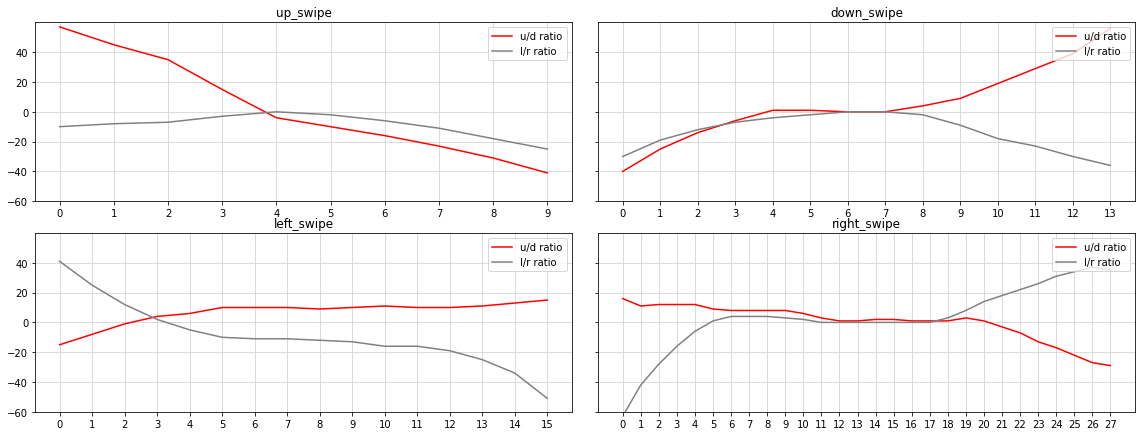

In [190]:
def gesture_ratios(dataframe):
    ud_ratios = []
    lr_ratios = []
    for data in dataframe:
        if all(x > 20 for x in data): # Prune out low-count entries that'll cause issues with our ratio math
            ud_ratio, lr_ratio = dataset_ratios_int(data)
            ud_ratios.append(ud_ratio)
            lr_ratios.append(lr_ratio)
            # print("{:<3d} {:<3d} {:<3d} {:<3d} | ud_r: {:< 4d} | lr_r: {:< 4d}".format(*data, ud_ratio, lr_ratio))
    return ud_ratios, lr_ratios

udr_ups, lrr_ups = gesture_ratios(up_swipe)
udr_downs, lrr_downs = gesture_ratios(down_swipe)
udr_lefts, lrr_lefts = gesture_ratios(left_swipe)
udr_rights, lrr_rights = gesture_ratios(right_swipe)

def plot_ratios(name, ud, lr, axis, legend_location="upper right"):
    axis.set_title(name)
    axis.plot(ud, color="red", label="u/d ratio")
    axis.plot(lr, color="gray", label="l/r ratio")
    axis.set(ylim=(-60, 60))
    axis.legend(loc=legend_location)
    axis.grid(visible=True, color="lightgray")
    axis.set_xticks(range(len(ud)))
    axis.set_yticks(range(-60, 60, 20))

fig, axs = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(16,6))
fig.tight_layout()
plot_ratios("up_swipe", udr_ups, lrr_ups, axs[0,0], "upper right")
plot_ratios("down_swipe", udr_downs, lrr_downs, axs[0,1], "upper right")
plot_ratios("left_swipe", udr_lefts, lrr_lefts, axs[1,0], "upper right")
plot_ratios("right_swipe", udr_rights, lrr_rights, axs[1,1], "upper right")

plt.show()

Visualization helps bring out the "signals" here, which are 

In the `up_swipe` case our signal is only in the first half of the dataframe. In the U/D ratio plot we can see an early high positive ratio slowly decreasing to the `0` point mid-gesture before entring negative territory before end-of-event. Throughout the plot the L/R ratio is a lot more stable but it does show some variation, including a moderate correlation with the U/D ratio through the final few datasets. The others show similar, if a bit more pronounced and sometimes reversed, patterns.

So U/D ratio and L/R ratio are definitely valid indicators over time.

The current implementation (in driver v2.8.2) only evaluates the _first dataset_ in the dataframe it acquires, ignoring the rest. This is complicated by the fact that it tracks state across dataframe read-ins, which can lead to some weird accumulated values over multiple reads. With the above visualization we can see how this implementation will cause issues with detecting many real-world gestures, like the `down_swipe` example above, in which the starting U/D and L/R ratios are very similar. Those issues can be compounded by the nature and frequency of data frames being received/processed as well, which is another interesting problem.

A more accurate algorithm should ideally look a change in ratios a wider timeframe, ideally the true start/end of a detected gesture. Looking at all data sets is a lot of work though. We could optimize by isolating only important-looking fragments of a dataframe though.

The Ardunio driver optimizes here , within `processGestureData()`, by selecting the two most interesting looking datasets in the dataframe. Here it decides ratios based on only those two datasets, effectively ignoring the rest of the frame, before it uses those to determine deltas between them.

From here it goes one step further, using those deltas make an inference about potential activity. Those basic decisions are broken out in `detect_state_arduno_style()` below with the 'near/far' decisions removed for simplicity. Although those can be useful, in aggregate, for taking into account saturation (all-255), sensor-empty (all-0, or close to it), or marginal (delta-under-threshold) sets I've left it out here to simplify an already complex algorithm. :)

In the Arduino driver those inferences are used to update global counters that are used later by `decodeGestureData()`. Here, since we're looking at an entire dataframe, dealing with those global variables isn't important.

In [150]:
COUNT_THRESHOLD = 30 # set to 10 in arduino driver, GESTURE_THRESHOLD_OUT
GESTURE_SENSITIVITY = 50 # set to 50 in arduino driver, GESTURE_SENSITIVITY_1

def find_first(dataframe, count_threshold):
    """Return first dataset in dataframe with all values over count_threshold"""
    idx = 0
    for early_gesture_tuple in dataframe:
        if (early_gesture_tuple[0] > count_threshold and
            early_gesture_tuple[1] > count_threshold and
            early_gesture_tuple[2] > count_threshold and
            early_gesture_tuple[3] > count_threshold):
                first_data = early_gesture_tuple
                # print("FIRST: [{}] {}".format(idx, first_data))
                return first_data # Stop iterating and return on our first hit
        else:
            idx += 1

def find_last(dataframe, count_threshold):
    """Return last dataset in dataframe with all values over count_threshold"""
    idx = 0
    for reverse_gesture_tuple in reversed(dataframe):
        if (reverse_gesture_tuple[0] > count_threshold and
            reverse_gesture_tuple[1] > count_threshold and
            reverse_gesture_tuple[2] > count_threshold and
            reverse_gesture_tuple[3] > count_threshold):
                last_data = reverse_gesture_tuple
                # print("LAST:  [{}] {}".format(len(dataframe) - idx, last_data))
                return last_data # Stop iterating on our first hit
    else:
        idx += 1

def detect_state_arduino_style(ud_delta, lr_delta, gesture_sensitivity):
    # First, gather gesture state from our deltas
    ud_state = 0
    lr_state = 0

    if ud_delta >= gesture_sensitivity:
        ud_state = 1
    elif ud_delta <= -gesture_sensitivity:
        ud_state = -1
    
    if lr_delta >= gesture_sensitivity:
        lr_state = 1
    elif lr_delta <= -gesture_sensitivity:
        lr_state = -1

    return ud_state, lr_state

def process_ardunio_style(name, dataframe, threshold, print_data=False):
    processed_data= {}
    processed_data['name'] = name
    processed_data['first_set'] = find_first(dataframe, threshold)
    processed_data['last_set'] = find_last(dataframe, threshold)
    processed_data['first_ratios'] = dataset_ratios_int(processed_data['first_set'])
    processed_data['last_ratios'] = dataset_ratios_int(processed_data['last_set'])
    processed_data['ud_delta'] = processed_data['last_ratios'][0] - processed_data['first_ratios'][0]
    processed_data['lr_delta'] = processed_data['last_ratios'][1] - processed_data['first_ratios'][1]
    processed_data['state'] = detect_state_arduino_style(processed_data['ud_delta'], processed_data['lr_delta'], GESTURE_SENSITIVITY)

    if print_data:
        print("{:<11s} | first: ({:<3d} {:<3d} {:<3d} {:<3d}) last: ({:<3d} {:<3d} {:<3d} {:<3d}) | ratios, f: ({:< 4d}, {:< 4d}), l: ({:< 4d}, {:< 4d}) | deltas, ud: {:< 4d}, lr: {:< 4d} | state: {: 2d},{: 2d}".format(
            processed_data['name'], *processed_data['first_set'], *processed_data['last_set'], 
            *processed_data['first_ratios'], *processed_data['last_ratios'], processed_data['ud_delta'], processed_data['lr_delta'], *processed_data['state']))

    return processed_data

up_processed = process_ardunio_style("up_swipe", up_swipe, COUNT_THRESHOLD, True)
down_processed = process_ardunio_style("down_swipe", down_swipe, COUNT_THRESHOLD, True)
left_processed = process_ardunio_style("left_swipe", left_swipe, COUNT_THRESHOLD, True)
right_processed = process_ardunio_style("right_swipe", right_swipe, COUNT_THRESHOLD, True)

up_swipe    | first: (141 38  89  108) last: (31  74  36  59 ) | ratios, f: ( 57 , -10 ), l: (-41 , -25 ) | deltas, ud: -98 , lr: -15  | state: -1, 0
down_swipe  | first: (35  81  45  83 ) last: (130 36  49  104) | ratios, f: (-40 , -30 ), l: ( 56 , -36 ) | deltas, ud:  96 , lr: -6   | state:  1, 0
left_swipe  | first: (55  74  93  38 ) last: (94  72  49  99 ) | ratios, f: (-15 ,  41 ), l: ( 13 , -34 ) | deltas, ud:  28 , lr: -75  | state:  0,-1
right_swipe | first: (106 84  55  132) last: (43  74  73  33 ) | ratios, f: ( 11 , -42 ), l: (-27 ,  37 ) | deltas, ud: -38 , lr:  79  | state:  0, 1


The primary output of processing, aside from a few global var updates, is the "count" values for up/down and near/far. Those are used by `decodeGesture()` to make a final decision on what our movement state data actually means.

In [151]:
def decode_gesture_arduino_style(processed_data):
    ud_state = processed_data['state'][0]
    lr_state = processed_data['state'][1]

    # Easy cases
    if ud_state == -1 and lr_state == 0:
        return 'up'
    elif ud_state == 1 and lr_state == 0:
        return 'down'
    elif ud_state == 0 and lr_state == -1:
        return 'left'
    elif ud_state == 0 and lr_state == 1:
        return 'right'
    
    # Not so easy cases, gonna need delta data for these
    ud_delta = processed_data['ud_delta']
    lr_delta = processed_data['lr_delta']
    if ud_state == -1 and lr_state == 1:
        if abs(ud_delta) > abs(lr_delta):
            return 'up'
        else:
            return 'right'
    elif ud_state == 1 and lr_state == -1:
        if abs(ud_delta) > abs(lr_delta):
            return 'down'
        else:
            return 'left'
    elif ud_state == -1 and lr_state == -1:
        if abs(ud_delta) > abs(lr_delta):
            return 'up'
        else:
            return 'left'
    elif ud_state == 1 and lr_state == 1:
        if abs(ud_delta) > abs(lr_delta):
            return 'down'
        else:
            return 'left'

    return 'unknown'

print("up, decoded:    {}".format(decode_gesture_arduino_style(up_processed)))
print("down, decoded:  {}".format(decode_gesture_arduino_style(down_processed)))
print("left, decoded:  {}".format(decode_gesture_arduino_style(left_processed)))
print("right, decoded: {}".format(decode_gesture_arduino_style(right_processed)))

up, decoded:    up
down, decoded:  down
left, decoded:  left
right, decoded: right


And that's about it. The example code above was simplified in two ways from the Arduino driver.

First, global state tracking was eliminated since we're (ideally) looking at entire data frames.

Second, handling/processing of "near/far" states has been removed. Saturated states or states below a threshold can be filtered during acquisition by ignoring datasets that are non-saturated and have values within certain thresholds, removing the need to do that work during the dataframe processing operation.

So, yeah, the Ardunio driver's algorithm works pretty well in comparison to the CircuitPython v2.8.2 driver. There may be opportunities to enhance the algorithm in a a few areas. These are the ones that come to mind immediately.

1. Accuracy improvements by isolating movement "segments"
    * ie, begin/end

Feature enhancements are also possible too.

1. Add handling for detections of "in" and "out" events, or permutations of events.
    * These will generally have two traits:
        * All datasets will have relatively low L/R and U/D ratios
        * Frames will start with very high (saturated or almost-saturated) or very low (zero or non-saturated) values
        * Frames will end with very low or very high values (opposite to start)

## Appendix: Gesture Dataset Filtering

One easy optimization involves only passing on the data we actually care about.

As long as the 'should_filter' test is simple enough we can apply this filtering _during acquisition_ and before we actually add new data frames to our returned list.

There are three categories of items that we won't find very useful for the kind of ratio-based processing noted above.

1. All-max-value (high-clipping)
2. All-zero-value (low-clipping)
3. One or more very low values present (high-pass)

In [4]:
set_test = [
    (123, 255, 255, 255), # Keep
    (255, 255, 255, 255), # Remove: Clipping
    (0, 0, 0, 0),         # Remove: Zeroes
    (19, 19, 19, 19),     # Remove: All Below Threshold
    (19, 19, 19, 255)     # Remove: Some Below Threshold
]

high_pass_test_threshold = 20

def filter_dataset_demo(dataset, low_threshold: int) -> bool:
    if all(val == 255 for val in dataset):
        print("({:3d}, {:3d}, {:3d}, {:3d}) | Nope... Too Clipped".format(*dataset))
        return False
    elif all(val == 0 for val in dataset):
        print("({:3d}, {:3d}, {:3d}, {:3d}) | Nope... Too Zeroey".format(*dataset))
        return False
    elif not all(val >= low_threshold for val in dataset):
        print("({:3d}, {:3d}, {:3d}, {:3d}) | Nope... Too Low".format(*dataset))
        return False
    else:
        print("({:3d}, {:3d}, {:3d}, {:3d}) | KEEPER!".format(*dataset))

# print(tuple(val >= 20 for val in set_test[4]))
# print(all(val >= 20 for val in set_test[4]))

for s in set_test:
    filter_dataset_demo(s, high_pass_test_threshold)

(123, 255, 255, 255) | KEEPER!
(255, 255, 255, 255) | Nope... Too Clipped
(  0,   0,   0,   0) | Nope... Too Zeroey
( 19,  19,  19,  19) | Nope... Too Low
( 19,  19,  19, 255) | Nope... Too Low
